In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import io

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [2]:
from utils import *
from data import *
from models import *
from train import *

In [3]:
%run data.py
%run utils.py
%run models.py
%run train.py

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Import

In [5]:
data_1lead = import_afc_data()

labelmap = {x:i for i,x in enumerate(list(set([x[1] for x in data_1lead])))}

dataset_1lead = WindowDataset(data_1lead, labelmap, device=device)

100%|██████████| 8528/8528 [00:00<00:00, 21001.35it/s]


In [6]:
data_12lead = import_balanced_12lead_data()

# dataset_12lead = WindowDataset(data_12lead, labelmap, device=device)

In [7]:
dataset_12lead = WindowDataset(data_12lead, labelmap, device=device, trim_samples=1000)


In [8]:
pd.Series([x[1] for x in data_1lead]).value_counts()

N    5076
O    2415
A     758
~     279
Name: count, dtype: int64

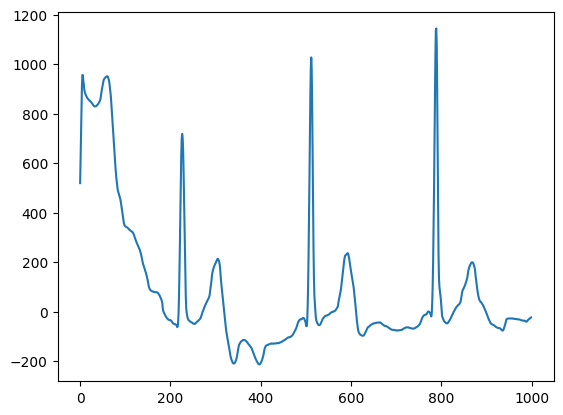

In [9]:
def plotwave(x, n=1000):
    plt.plot(x[:n])

plotwave(data_1lead[3][0])

In [10]:
value_counts = dataset_1lead.get_value_counts()
weights = [sum(value_counts)/x for x in value_counts]
weights[labelmap['~']] = weights[labelmap['N']]

# Training

In [11]:
## Train k-fold crossvalidated model on 1 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap

# history = train_kfold_model(dataset_1lead, trainparams, test=)

# plot_tt_graph(history, idx=0)
# display_results(history,trainparams=trainparams)

In [12]:
## Build model on entire 1lead dataset and save to buffer

buffer = io.BytesIO()

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs = 200

model, history = train_entire_model(dataset_1lead, trainparams)

torch.save(model.state_dict(), buffer)

Epoch:10/200 AVG Training Loss:0.02511 AVG Test Loss:0.02397 AVG Training Acc 53.14 % AVG Test Acc 52.53 %
Epoch:20/200 AVG Training Loss:0.02284 AVG Test Loss:0.02153 AVG Training Acc 58.60 % AVG Test Acc 60.81 %
Epoch:30/200 AVG Training Loss:0.02195 AVG Test Loss:0.02093 AVG Training Acc 62.63 % AVG Test Acc 63.40 %
Epoch:40/200 AVG Training Loss:0.02093 AVG Test Loss:0.02004 AVG Training Acc 65.87 % AVG Test Acc 68.47 %
Epoch:50/200 AVG Training Loss:0.02049 AVG Test Loss:0.01969 AVG Training Acc 65.13 % AVG Test Acc 69.78 %
Epoch:60/200 AVG Training Loss:0.02007 AVG Test Loss:0.01859 AVG Training Acc 66.58 % AVG Test Acc 65.40 %
Epoch:70/200 AVG Training Loss:0.01983 AVG Test Loss:0.01838 AVG Training Acc 67.42 % AVG Test Acc 69.96 %
Epoch:80/200 AVG Training Loss:0.01987 AVG Test Loss:0.01789 AVG Training Acc 67.06 % AVG Test Acc 69.17 %
Epoch:90/200 AVG Training Loss:0.01915 AVG Test Loss:0.01795 AVG Training Acc 68.14 % AVG Test Acc 70.88 %
Epoch:100/200 AVG Training Loss:0.019

In [13]:
len(dataset_12lead)/20

165.9

Fold 1
Epoch:10/100 AVG Training Loss:0.00753 AVG Test Loss:0.00563 AVG Training Acc 67.37 % AVG Test Acc 68.36 %
Epoch:20/100 AVG Training Loss:0.00650 AVG Test Loss:0.00545 AVG Training Acc 74.32 % AVG Test Acc 69.50 %
Epoch:30/100 AVG Training Loss:0.00588 AVG Test Loss:0.00551 AVG Training Acc 78.55 % AVG Test Acc 69.57 %
Epoch:40/100 AVG Training Loss:0.00510 AVG Test Loss:0.00522 AVG Training Acc 84.59 % AVG Test Acc 72.21 %
Epoch:50/100 AVG Training Loss:0.00478 AVG Test Loss:0.00574 AVG Training Acc 86.10 % AVG Test Acc 71.14 %
Early stopping triggered after epoch 52
Fold 2
Epoch:10/100 AVG Training Loss:0.00717 AVG Test Loss:0.00568 AVG Training Acc 74.62 % AVG Test Acc 70.14 %
Epoch:20/100 AVG Training Loss:0.00587 AVG Test Loss:0.00539 AVG Training Acc 81.27 % AVG Test Acc 69.87 %
Epoch:30/100 AVG Training Loss:0.00531 AVG Test Loss:0.00522 AVG Training Acc 83.38 % AVG Test Acc 71.95 %
Epoch:40/100 AVG Training Loss:0.00447 AVG Test Loss:0.00536 AVG Training Acc 86.40 % AVG 

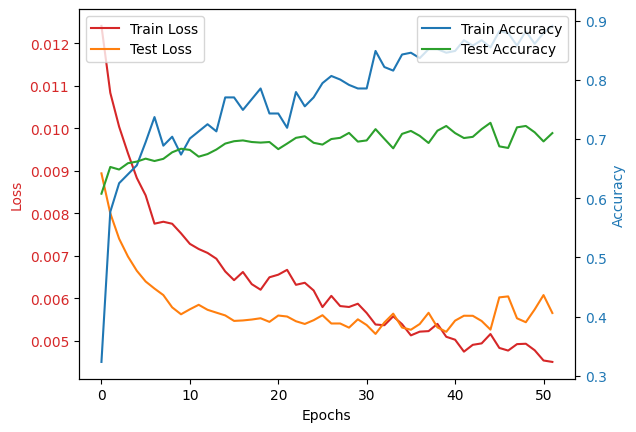

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.004678897316921952, average accuracy 89.96360062606922
Test: Average loss 0.005590407247857054, average accuracy 73.41440167943651


In [15]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/200 AVG Training Loss:0.01030 AVG Test Loss:0.00894 AVG Training Acc 35.65 % AVG Test Acc 40.58 %
Epoch:20/200 AVG Training Loss:0.00867 AVG Test Loss:0.00780 AVG Training Acc 58.01 % AVG Test Acc 55.11 %
Epoch:30/200 AVG Training Loss:0.00720 AVG Test Loss:0.00743 AVG Training Acc 69.49 % AVG Test Acc 56.81 %
Epoch:40/200 AVG Training Loss:0.00663 AVG Test Loss:0.00754 AVG Training Acc 73.11 % AVG Test Acc 57.15 %
Epoch:50/200 AVG Training Loss:0.00540 AVG Test Loss:0.00736 AVG Training Acc 77.04 % AVG Test Acc 60.93 %
Epoch:60/200 AVG Training Loss:0.00439 AVG Test Loss:0.00745 AVG Training Acc 81.87 % AVG Test Acc 60.56 %
Early stopping triggered after epoch 64
Fold 2
Epoch:10/200 AVG Training Loss:0.01051 AVG Test Loss:0.00903 AVG Training Acc 36.86 % AVG Test Acc 43.66 %
Epoch:20/200 AVG Training Loss:0.00883 AVG Test Loss:0.00797 AVG Training Acc 54.68 % AVG Test Acc 52.70 %
Epoch:30/200 AVG Training Loss:0.00737 AVG Test Loss:0.00754 AVG Training Acc 67.67 % AVG 

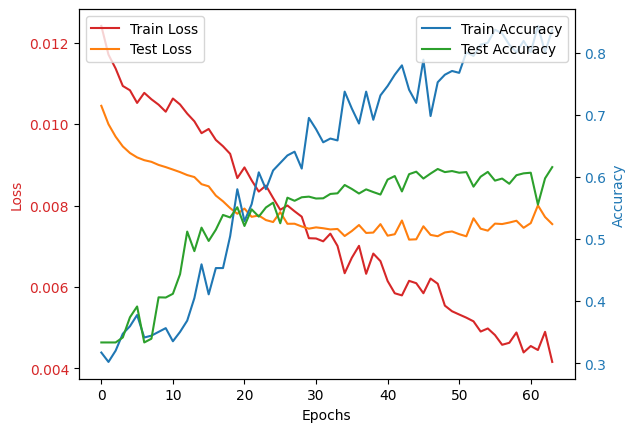

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.003254588309189878, average accuracy 90.08208058821388
Test: Average loss 0.007300008285691674, average accuracy 63.88061707901016


In [16]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs=200
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

In [ ]:
transfer_def = TransferDef()
transfer_def.return_request = [4]

from torch.utils.tensorboard import SummaryWriter

model = TransferModel(buffer, transfer_def)

# Initialize the summary writer
writer = SummaryWriter()

# Create dummy input that corresponds to the network's input shape
input_tensor = torch.rand(128, 1000, 12)

# Add the model graph to TensorBoard
writer.add_graph(model, input_tensor)
writer.close()


# test_forwards(model, data_12lead, labelmap, device)

TypeError: TransferModel.forward() missing 1 required positional argument: 'return_request'